In [ ]:
import os
import pickle
from PIL import Image, UnidentifiedImageError
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms
from torchvision.models import resnet50
from tqdm.auto import tqdm
from skimage import filters
from skimage.color import rgb2gray
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import gc
import math
import torchvision.models as models



# Set random seed
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#%matplotlib inline
import torch
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.version.cuda)         # CUDA version used by PyTorch
print(torch.backends.cudnn.version())  # cuDNN version


limit = 3500
learning_rate = 0.0001
num_epochs =40
batchsize = 16

gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



False
0
None
None


In [ ]:

# Decoder Block using ConvTranspose2d 

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        # Upsampling via transpose convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # After upsampling, concatenate with the skip connection (channels add up)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        x = self.up(x)                  # Upsample
        x = torch.cat([x, skip], dim=1)   # Concatenate with skip connection
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x


# Res-UNet without CSDA or Dropout (ResNet50 Backbone)

class ResUnet_NoCSDA_NoDropout(nn.Module):
    def __init__(self):
        super(ResUnet_NoCSDA_NoDropout, self).__init__()
        # Load a ResNet50 backbone (set pretrained=True if needed)
        base = models.resnet50(weights=None)
        self.conv1 = base.conv1      # For a 256×256 input, produces ~128×128 output
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool  # Downsamples to 64×64
        self.layer1 = base.layer1    # 64×64, 256 channels
        self.layer2 = base.layer2    # 32×32, 512 channels
        self.layer3 = base.layer3    # 16×16, 1024 channels
        self.layer4 = base.layer4    # 8×8, 2048 channels (bottleneck)

        # Decoder blocks using fixed upsampling (ConvTranspose2d)
        self.decoder1 = DecoderBlock(in_channels=2048, skip_channels=1024, out_channels=1024)  # 8×8 → 16×16
        self.decoder2 = DecoderBlock(in_channels=1024, skip_channels=512, out_channels=512)    # 16×16 → 32×32
        self.decoder3 = DecoderBlock(in_channels=512, skip_channels=256, out_channels=256)     # 32×32 → 64×64
        self.decoder4 = DecoderBlock(in_channels=256, skip_channels=64, out_channels=64)       # 64×64 → 128×128

        # Final upsampling to reach 256×256 and produce a 1-channel output
        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128×128 → 256×256
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Encoder: using ResNet50 layers
        x1 = self.relu(self.bn1(self.conv1(x)))  # x1: ~128×128, 64 channels
        x2 = self.maxpool(x1)                    # x2: 64×64, 64 channels
        x2 = self.layer1(x2)                     # x2: 64×64, 256 channels
        x3 = self.layer2(x2)                     # x3: 32×32, 512 channels
        x4 = self.layer3(x3)                     # x4: 16×16, 1024 channels
        x5 = self.layer4(x4)                     # x5: 8×8, 2048 channels

        # Decoder: use encoder features as skip connections
        d1 = self.decoder1(x5, x4)  # 8×8 → 16×16
        d2 = self.decoder2(d1, x3)  # 16×16 → 32×32
        d3 = self.decoder3(d2, x2)  # 32×32 → 64×64
        d4 = self.decoder4(d3, x1)  # 64×64 → 128×128

        up = self.final_up(d4)      # 128×128 → 256×256
        out = self.final_conv(up)
        out = self.final_activation(out)
        return out

import torch
import torch.nn as nn
import torch.nn.functional as F

def channel_shuffle(x, groups=2):
    """
    Rearranges channels into groups and shuffles them.
    x: (B, C, H, W)
    groups: number of channel groups
    """
    batch_size, num_channels, height, width = x.size()
    if num_channels % groups != 0:
        raise ValueError("Number of channels must be divisible by groups.")
    channels_per_group = num_channels // groups

    # (B, groups, channels_per_group, H, W)
    x = x.view(batch_size, groups, channels_per_group, height, width)
    # Transpose -> (B, channels_per_group, groups, H, W)
    x = torch.transpose(x, 1, 2).contiguous()
    # Flatten -> (B, C, H, W)
    x = x.view(batch_size, -1, height, width)
    return x

# ------------------------------------------------
# Channel Attention Block (CAB)
# ------------------------------------------------
class CAB(nn.Module):
    """
    Channel Attention Block (CAB):
      - Parallel Global Max Pool (GMP) & Global Avg Pool (GAP)
      - Each path: 1x1 Conv -> Swish -> 1x1 Conv -> Sigmoid
      - Summation of attention maps -> multiplied with input
    """
    def __init__(self, channels, reduction=8):
        super(CAB, self).__init__()
        # MLP for max-pooling branch
        self.conv_max_1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.conv_max_2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)

        # MLP for avg-pooling branch
        self.conv_avg_1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.conv_avg_2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)

        self.act = nn.SiLU()     # or a custom Swish
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global Max Pool
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = self.conv_max_1(x_max)
        x_max = self.act(x_max)
        x_max = self.conv_max_2(x_max)
        x_max = self.sigmoid(x_max)

        # Global Average Pool
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = self.conv_avg_1(x_avg)
        x_avg = self.act(x_avg)
        x_avg = self.conv_avg_2(x_avg)
        x_avg = self.sigmoid(x_avg)

        # Sum attention maps
        x_att = x_max + x_avg  # shape: (B, C, 1, 1)

        # Multiply input by attention
        out = x * x_att
        return out

# ------------------------------------------------
# Spatial Attention Block (SAB)
# ------------------------------------------------
class SAB(nn.Module):
    """
    Spatial Attention Block (SAB):
      - Channel-wise max & avg pooling -> concat -> 7x7 conv -> Sigmoid
      - Multiply with input
    """
    def __init__(self, kernel_size=7):
        super(SAB, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, H, W)
        x_max, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, H, W)
        x_avg = torch.mean(x, dim=1, keepdim=True)    # (B, 1, H, W)
        x_cat = torch.cat([x_max, x_avg], dim=1)      # (B, 2, H, W)
        att_map = self.conv(x_cat)                    # (B, 1, H, W)
        att_map = self.sigmoid(att_map)
        out = x * att_map
        return out

# ------------------------------------------------
# Channel Shuffle Dual Attention (CSDA)
# Modified final output:
#   A_final = A_shuffle + A_channel + A_spatial
# ------------------------------------------------
class CSDA(nn.Module):
    """
    CSDA:
      1) Channel Attention (CAB)
      2) Channel Shuffle
      3) Spatial Attention (SAB)
      4) Final output = sum of the above three feature maps
    """
    def __init__(self, channels, groups=2, reduction=8, kernel_size=7):
        super(CSDA, self).__init__()
        self.cab = CAB(channels, reduction=reduction)      # channel attention
        self.groups = groups
        self.sab = SAB(kernel_size=kernel_size)            # spatial attention

    def forward(self, x):
        # 1) Channel Attention => A_channel
        A_channel = self.cab(x)  # shape (B, C, H, W)

        # 2) Channel Shuffle => A_shuffle
        A_shuffle = channel_shuffle(x, groups=self.groups)  # same shape

        # 3) Spatial Attention => A_spatial
        A_spatial = self.sab(x)  # shape (B, C, H, W)

        # 4) Final: element-wise addition
        A_final = A_channel + A_shuffle + A_spatial

        return A_final

# ----------------------------
# Decoder Block using Upconv (ConvTranspose2d)
# ----------------------------
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        x = self.up(x)  # Upsample
        x = torch.cat([x, skip], dim=1)  # Concatenate with skip connection
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

# ----------------------------
# Res-Unet with CSDA using ResNet50 Backbone (without encoder dropout)
# ----------------------------
class ResUnetCSDA_NoDropout(nn.Module):
    def __init__(self):
        super(ResUnetCSDA_NoDropout, self).__init__()
        # Load pretrained ResNet50 backbone
        base = models.resnet50(weights=None)
        self.conv1 = base.conv1      # 128×128, 64 channels (for 256×256 input)
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool  # Downsamples to 64×64
        self.layer1 = base.layer1    # 64×64, 256 channels
        self.layer2 = base.layer2    # 32×32, 512 channels
        self.layer3 = base.layer3    # 16×16, 1024 channels
        self.layer4 = base.layer4    # 8×8, 2048 channels (bottleneck)

        # CSDA blocks for skip connections
        self.csda1 = CSDA(channels=64)    # From conv1 output (128×128)
        self.csda2 = CSDA(channels=256)   # From layer1 output (64×64)
        self.csda3 = CSDA(channels=512)   # From layer2 output (32×32)
        self.csda4 = CSDA(channels=1024)  # From layer3 output (16×16)

        # Decoder blocks using upconv
        self.decoder1 = DecoderBlock(2048, 1024, 1024)  # 8×8 → 16×16
        self.decoder2 = DecoderBlock(1024, 512, 512)    # 16×16 → 32×32
        self.decoder3 = DecoderBlock(512, 256, 256)     # 32×32 → 64×64
        self.decoder4 = DecoderBlock(256, 64, 64)       # 64×64 → 128×128

        # Final upconv for 256×256 output
        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128→256
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Encoder without dropout
        x1 = self.relu(self.bn1(self.conv1(x)))  # 128×128, 64 channels
        x2 = self.maxpool(x1)
        x2 = self.layer1(x2)                     # 64×64, 256 channels
        x3 = self.layer2(x2)                     # 32×32, 512 channels
        x4 = self.layer3(x3)                     # 16×16, 1024 channels
        x5 = self.layer4(x4)                     # 8×8, 2048 channels (bottleneck)

        # Process encoder outputs with CSDA
        s1 = self.csda1(x1)  # 128×128, 64 channels
        s2 = self.csda2(x2)  # 64×64, 256 channels
        s3 = self.csda3(x3)  # 32×32, 512 channels
        s4 = self.csda4(x4)  # 16×16, 1024 channels

        # Decoder: upsample and merge with CSDA-processed skip connections
        d1 = self.decoder1(x5, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        up = self.final_up(d4)
        out = self.final_conv(up)
        out = self.final_activation(out)
        return out

In [4]:
!pip install empatches

You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for empatches, since package 'wheel' is not installed.
    Running setup.py install for empatches: started
    Running setup.py install for empatches: finished with status 'done'


Merged Image Range: 0.0 to 255.0


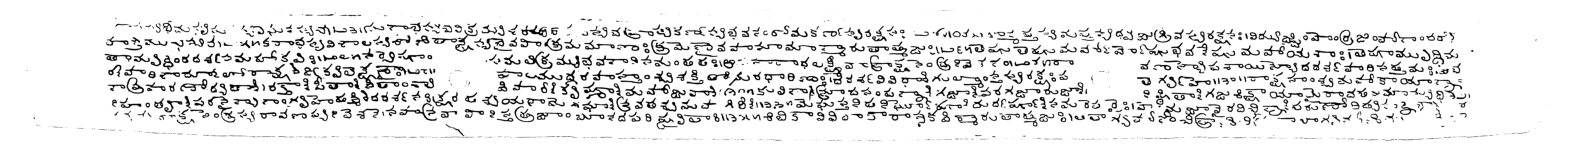

In [ ]:
from empatches import EMPatches
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

#  Define padding helpers
def pad_image_to_multiple(image, multiple=32):
    h, w, c = image.shape
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

def pad_tensor_to_multiple(tensor, multiple=32):
    _, _, h, w = tensor.shape
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    tensor_padded = F.pad(tensor, (0, pad_w, 0, pad_h), mode='reflect')
    return tensor_padded, (h, w)

# 1. Load image
img = cv2.imread(r"C:\Users\ASUS\Documents\Major\00000001 (6) (2).jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = pad_image_to_multiple(img, multiple=32)  # ✅ Pad before patch extraction

# 2. Load model
model_path = r"C:\Users\ASUS\Documents\Major\binarization.pth"
model = ResUnetCSDA_NoDropout()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3. Extract patches
emp = EMPatches()
patches, coords = emp.extract_patches(img, patchsize=512, overlap=0)

# 4. Process patches
processed_patches = []
for idx, patch in enumerate(patches):
    patch_tensor = torch.tensor(patch).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    patch_tensor = patch_tensor.to(device)

    # ✅ Proper tensor padding
    patch_tensor, (orig_h, orig_w) = pad_tensor_to_multiple(patch_tensor)

    with torch.no_grad():
        processed_patch = model(patch_tensor)
        processed_patch = torch.sigmoid(processed_patch).cpu().numpy().squeeze()
        processed_patch = (processed_patch > 0.5).astype(np.float32)

    processed_patch = processed_patch[:orig_h, :orig_w]  # Crop back
    processed_patch = (processed_patch * 255).astype(np.uint8)

    if processed_patch.ndim == 2:
        processed_patch = cv2.cvtColor(processed_patch, cv2.COLOR_GRAY2RGB)

    processed_patches.append(processed_patch)

# 5. Merge
processed_patches = np.array(processed_patches)
merged_img = emp.merge_patches(processed_patches, coords)

# Debug info
print(f"Merged Image Range: {merged_img.min()} to {merged_img.max()}")

# 6. Display
plt.figure(figsize=(20, 20))
plt.imshow(merged_img.astype(np.uint8))
plt.axis('off')
plt.savefig("ResNetUNetWithAttention.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [11]:
import os, glob
from pathlib import Path
from empatches import EMPatches
import cv2
import numpy as np
import torch
import torch.nn.functional as F

# ----------------------------
# Config: change these paths
# ----------------------------
input_dir  = r"C:\Users\ASUS\Documents\Major\cropped_images"  # folder with all palm leaf images
output_dir = r"C:\Users\ASUS\Documents\Major\outputs"          # folder to save binarized images
model_path = r"C:\Users\ASUS\Documents\Major\binarization.pth"

# ----------------------------
# Helpers
# ----------------------------
def pad_image_to_multiple(image, multiple=32):
    h, w = image.shape[:2]
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT), (h, w)

def pad_tensor_to_multiple(tensor, multiple=32):
    _, _, h, w = tensor.shape
    new_h = ((h + multiple - 1) // multiple) * multiple
    new_w = ((w + multiple - 1) // multiple) * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    tensor_padded = F.pad(tensor, (0, pad_w, 0, pad_h), mode='reflect')
    return tensor_padded, (h, w)

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResUnetCSDA_NoDropout()
    state = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state, strict=False)
    model.eval().to(device)
    return model, device

def binarize_image_with_patches(img_rgb, model, device, patchsize=512, overlap=0):
    # Keep original size to crop after global padding
    (orig_h, orig_w) = img_rgb.shape[:2]

    # Global pad to 32-multiple before patching
    img_padded, (oh, ow) = pad_image_to_multiple(img_rgb, multiple=32)

    emp = EMPatches()
    patches, coords = emp.extract_patches(img_padded, patchsize=patchsize, overlap=overlap)

    processed_patches = []
    for patch in patches:
        # To tensor (B,C,H,W) in [0,1]
        patch_tensor = torch.tensor(patch).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        patch_tensor = patch_tensor.to(device)

        # Per-patch pad to 32-multiple for the network
        patch_tensor, (ph, pw) = pad_tensor_to_multiple(patch_tensor, multiple=32)

        # Inference
        with torch.no_grad():
            pred = model(patch_tensor)
            pred = torch.sigmoid(pred).cpu().numpy().squeeze()

        # Threshold -> binary
        pred = (pred > 0.5).astype(np.float32)

        # Remove per-patch padding
        pred = pred[:ph, :pw]

        # To 3-channel (EMPatches merge expects color-like patches)
        pred_u8 = (pred * 255).astype(np.uint8)
        if pred_u8.ndim == 2:
            pred_u8 = cv2.cvtColor(pred_u8, cv2.COLOR_GRAY2RGB)

        processed_patches.append(pred_u8)

    processed_patches = np.array(processed_patches)
    merged = emp.merge_patches(processed_patches, coords)

    # Crop away the global padding back to original size
    merged_cropped = merged[:orig_h, :orig_w]
    return merged_cropped

# ----------------------------
# Batch runner
# ----------------------------
def process_folder(input_dir, output_dir, model_path, exts=(".jpg",".jpeg",".png",".tif",".tiff",".bmp")):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(input_dir, f"*{ext}")))
    files = sorted(files)

    if not files:
        print(f"No images found in: {input_dir}")
        return

    model, device = load_model(model_path)
    print(f"Device: {device}, Images: {len(files)}")

    for i, f in enumerate(files, 1):
        try:
            img_bgr = cv2.imread(f)
            if img_bgr is None:
                print(f"[{i}/{len(files)}] Skipped (cannot read): {f}")
                continue

            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            bin_img_rgb = binarize_image_with_patches(img_rgb, model, device, patchsize=512, overlap=0)

            # Save as PNG with same stem
            out_path = os.path.join(output_dir, Path(f).stem + "_binarized.png")
            # Convert RGB->BGR for OpenCV write
            cv2.imwrite(out_path, cv2.cvtColor(bin_img_rgb.astype(np.uint8), cv2.COLOR_RGB2BGR))
            print(f"[{i}/{len(files)}] Saved: {out_path}")

        except Exception as e:
            print(f"[{i}/{len(files)}] ERROR on {f}: {e}")

# ----------------------------
# Run
# ----------------------------
process_folder(input_dir, output_dir, model_path)


Device: cpu, Images: 138
[1/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (1)_binarized.png
[2/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (2)_binarized.png
[3/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (3)_binarized.png
[4/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (4)_binarized.png
[5/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (5)_binarized.png
[6/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10) (6)_binarized.png
[7/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (10)_binarized.png
[8/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (11) (1)_binarized.png
[9/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (11) (2)_binarized.png
[10/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (11) (3)_binarized.png
[11/138] Saved: C:\Users\ASUS\Documents\Major\outputs\00000001 (11) (4)_binarized.png
[12/138] Saved: C:\Users\ASUS\Documents\Ma

Processing 10_binarized.jpg
  raw components: 941, kept after filters: 747, merged boxes: 721


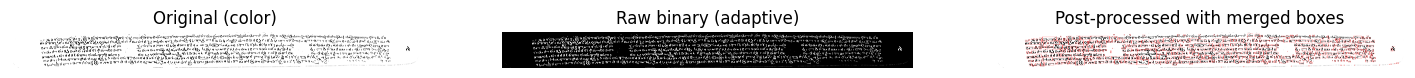

Processing 113_binarized.jpg
  raw components: 1049, kept after filters: 758, merged boxes: 735


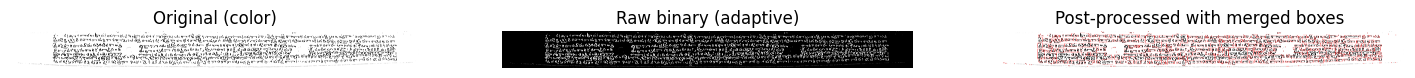

Processing 115_binarized.jpg
  raw components: 526, kept after filters: 430, merged boxes: 418


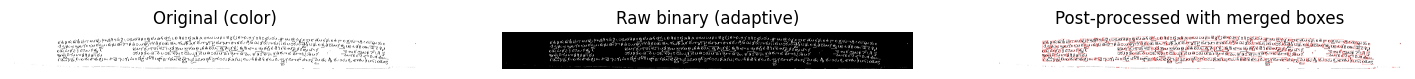

Processing 116_binarized.jpg
  raw components: 648, kept after filters: 435, merged boxes: 413


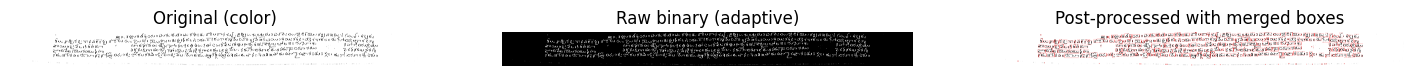

Processing 12_binarized.jpg
  raw components: 524, kept after filters: 408, merged boxes: 393


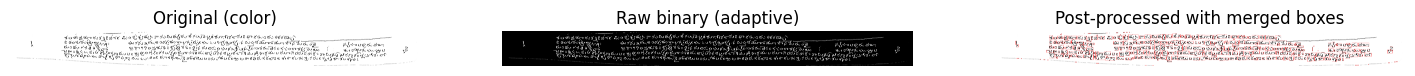

Processing 13_binarized.jpg
  raw components: 666, kept after filters: 452, merged boxes: 436


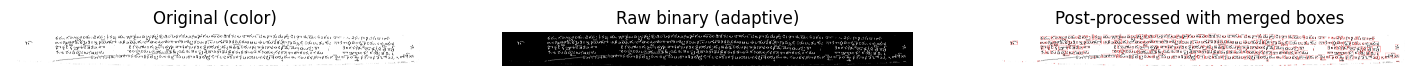

Processing 15_binarized.jpg
  raw components: 962, kept after filters: 561, merged boxes: 537
Processing 16_binarized.jpg
  raw components: 1354, kept after filters: 845, merged boxes: 816
Processing 17_binarized.jpg
  raw components: 502, kept after filters: 352, merged boxes: 338
Processing 19_binarized.jpg
  raw components: 688, kept after filters: 491, merged boxes: 478
Processing 20_binarized.jpg
  raw components: 649, kept after filters: 444, merged boxes: 427
Processing 21_binarized.jpg
  raw components: 731, kept after filters: 583, merged boxes: 562
Processing 23_binarized.jpg
  raw components: 663, kept after filters: 450, merged boxes: 433
Processing 27_binarized.jpg
  raw components: 669, kept after filters: 442, merged boxes: 423
Processing 28_binarized.jpg
  raw components: 624, kept after filters: 477, merged boxes: 465
Processing 30_binarized.jpg
  raw components: 627, kept after filters: 421, merged boxes: 402
Processing 34_binarized.jpg
  raw components: 632, kept aft

In [ ]:

import os, cv2, math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

# ---------------- CONFIG ----------------
input_dir = r"C:\Users\ASUS\Documents\Major\binarized_images"
output_dir = r"C:\Users\ASUS\Documents\Major\cc_crops"

# Preprocessing / morphology params (tune these)
adaptive_thresh = True           # False -> assume already 0/255 correct
adaptive_blocksize = 31
adaptive_C = 10

closing_kernel = (5,3)           # kernel size for closing (connect broken strokes). Try (5,3),(7,3),(9,5)
closing_iters = 1

dilate_kernel = (3,3)            # kernel for dilation (thicken strokes)
dilate_iters = 1                 # try 1..3

# Filtering and merging params
min_area = 80                    # reduce if tiny parts suppressed
max_area = 200000
min_aspect = 0.12
max_aspect = 6.0

merge_iou_threshold = 0.15       # merge boxes with IOU >= this
merge_dist_threshold = 20        # merge boxes if center distance <= this (pixels)
padding = 6

visualize = True
max_visualize = 6
# --------------------------------------

os.makedirs(output_dir, exist_ok=True)
img_exts = [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]
image_paths = sorted([str(p) for p in Path(input_dir).iterdir() if p.suffix.lower() in img_exts])
if not image_paths:
    raise FileNotFoundError(f"No images in {input_dir}.")

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB-xA); interH = max(0, yB-yA)
    inter = interW*interH
    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    denom = areaA + areaB - inter
    return inter/denom if denom>0 else 0.0

def merge_boxes(boxes):
    if not boxes: 
        return []
    boxes = boxes.copy()
    merged = True
    while merged:
        merged = False
        new_boxes = []
        used = [False]*len(boxes)
        for i, A in enumerate(boxes):
            if used[i]: continue
            ax1,ay1,ax2,ay2 = A
            merged_box = A
            used[i] = True
            for j,B in enumerate(boxes):
                if used[j]: continue
                bx1,by1,bx2,by2 = B
                # IOU or center distance check
                if iou(merged_box, B) >= merge_iou_threshold:
                    # merge
                    x1 = min(merged_box[0], bx1); y1 = min(merged_box[1], by1)
                    x2 = max(merged_box[2], bx2); y2 = max(merged_box[3], by2)
                    merged_box = (x1,y1,x2,y2)
                    used[j] = True
                    merged = True
                else:
                    # center distance
                    mx = (merged_box[0]+merged_box[2])/2; my = (merged_box[1]+merged_box[3])/2
                    bx = (bx1+bx2)/2; by = (by1+by2)/2
                    dist = math.hypot(mx-bx, my-by)
                    if dist <= merge_dist_threshold:
                        x1 = min(merged_box[0], bx1); y1 = min(merged_box[1], by1)
                        x2 = max(merged_box[2], bx2); y2 = max(merged_box[3], by2)
                        merged_box = (x1,y1,x2,y2)
                        used[j] = True
                        merged = True
            new_boxes.append(merged_box)
        boxes = new_boxes
    return boxes

summary = []
vis_count = 0

for img_path in image_paths:
    img_name = Path(img_path).name
    print(f"Processing {img_name}")
    color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    # 1) thresholding
    if adaptive_thresh:
        bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, adaptive_blocksize, adaptive_C)
    else:
        # assume binary but fix polarity
        uniq = np.unique(gray)
        if len(uniq)>2:
            # fallback
            _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            bw = cv2.bitwise_not(bw)  # ensure foreground white
        else:
            if np.mean(gray==0) > np.mean(gray==255):
                bw = cv2.bitwise_not(gray)
            else: 
                bw = gray.copy()
            bw = (bw>127).astype(np.uint8)*255

    # show original binary quick check (optional)
    # 2) morphological closing to connect broken segments
    kernel_cl = cv2.getStructuringElement(cv2.MORPH_RECT, closing_kernel)
    bw_closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel_cl, iterations=closing_iters)

    # 3) dilation to thicken strokes a little
    kernel_d = cv2.getStructuringElement(cv2.MORPH_RECT, dilate_kernel)
    bw_dil = cv2.dilate(bw_closed, kernel_d, iterations=dilate_iters)

    # 4) optional small opening to remove tiny specks (careful with opening)
    # bw_proc = cv2.morphologyEx(bw_dil, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(2,2)), iterations=1)
    bw_proc = bw_dil

    # 5) connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw_proc, connectivity=8)
    comps = []
    for lbl in range(1, num_labels):
        x,y,w,h,area = stats[lbl]
        if area < min_area or area > max_area: 
            continue
        aspect = w/h if h>0 else 0
        if not (min_aspect <= aspect <= max_aspect):
            continue
        comps.append((x,y,x+w,y+h))

    # 6) merge nearby/overlapping boxes (fragments -> whole character)
    merged = merge_boxes(comps)

    # 7) save crops and summary
    base_out = os.path.join(output_dir, Path(img_path).stem)
    os.makedirs(base_out, exist_ok=True)
    count = 0
    for i,box in enumerate(merged):
        x1,y1,x2,y2 = map(int, box)
        # add padding
        x1p = max(0, x1-padding); y1p = max(0, y1-padding)
        x2p = min(gray.shape[1], x2+padding); y2p = min(gray.shape[0], y2+padding)
        crop = color[y1p:y2p, x1p:x2p]
        outname = f"{Path(img_path).stem}_ccm_{i:03d}.png"
        outpath = os.path.join(base_out, outname)
        cv2.imwrite(outpath, crop)
        summary.append({"image":img_name, "box":(x1p,y1p,x2p,y2p), "area":(x2p-x1p)*(y2p-y1p), "path":outpath})
        count += 1

    print(f"  raw components: {num_labels-1}, kept after filters: {len(comps)}, merged boxes: {len(merged)}")

    # visualization
    if visualize and vis_count < max_visualize:
        fig, axs = plt.subplots(1,3, figsize=(18,6))
        axs[0].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB)); axs[0].set_title("Original (color)"); axs[0].axis("off")
        axs[1].imshow(bw, cmap='gray'); axs[1].set_title("Raw binary (adaptive)"); axs[1].axis("off")
        proc_vis = cv2.cvtColor(color.copy(), cv2.COLOR_BGR2RGB)
        for (x1,y1,x2,y2) in merged:
            cv2.rectangle(proc_vis, (x1,y1), (x2,y2), (255,0,0), 2)
        axs[2].imshow(proc_vis); axs[2].set_title("Post-processed with merged boxes"); axs[2].axis("off")
        plt.show()
        vis_count += 1

# save CSV
df = pd.DataFrame(summary)
if not df.empty:
    df['x1'] = df['box'].apply(lambda b:b[0]); df['y1'] = df['box'].apply(lambda b:b[1])
    df['x2'] = df['box'].apply(lambda b:b[2]); df['y2'] = df['box'].apply(lambda b:b[3])
    df = df[['image','x1','y1','x2','y2','area','path']]
    df.to_csv(os.path.join(output_dir, "cc_improved_summary.csv"), index=False)

print("Done. Output crops and CSV in:", output_dir)


In [ ]:
# Telugu CC crops -> Feature extraction -> KMeans -> Medoid templates 

# Requirements: torch, torchvision, sklearn, opencv-python, pandas, numpy, tqdm, joblib

import os, cv2, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch, torchvision
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import joblib

# ---------------- USER CONFIG ----------------
cc_root = r"C:\Users\ASUS\Documents\Major\cc_crops"   # root folder containing multiple leaf folders
out_dir = r"C:\Users\ASUS\Documents\Major\step_features_kmeans"
device = "cuda" if torch.cuda.is_available() else "cpu"

K = 1200             # initial number of clusters
pca_dim = 128        # reduce feature dim for clustering
batch_size = 64
resize = (224, 224)
img_exts = [".png", ".jpg", ".jpeg"]
# ------------------------------------------------

os.makedirs(out_dir, exist_ok=True)
templates_dir = os.path.join(out_dir, "auto_templates")
os.makedirs(templates_dir, exist_ok=True)

# 1️⃣ Gather all CC images recursively
img_paths = []
for ext in img_exts:
    img_paths += sorted([str(p) for p in Path(cc_root).rglob(f"*{ext}")])
n = len(img_paths)
if n == 0:
    raise FileNotFoundError(f"No images found in {cc_root}. Check your folder path.")
print(f"[INFO] Found {n} component crops across all palm leaves.")

# 2️⃣ Load pretrained ResNet50 (encoder)
resnet = torchvision.models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove FC
resnet.eval().to(device)

preproc = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 3️⃣ Extract 2048-d features
feats = np.zeros((n, 2048), dtype=np.float32)
paths = []
with torch.no_grad():
    for i in tqdm(range(0, n, batch_size), desc="Extracting features"):
        batch_paths = img_paths[i:i+batch_size]
        imgs = []
        for p in batch_paths:
            im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if im is None:
                im = np.zeros(resize, dtype=np.uint8)
            im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
            imgs.append(preproc(im))
            paths.append(p)
        batch = torch.stack(imgs).to(device)
        out = resnet(batch).view(batch.size(0), -1).cpu().numpy()
        feats[i:i+len(batch_paths)] = out

# Normalize features (L2)
feats = feats / (np.linalg.norm(feats, axis=1, keepdims=True) + 1e-8)
np.save(os.path.join(out_dir, "features_raw.npy"), feats)
pd.DataFrame({"path": paths}).to_csv(os.path.join(out_dir, "image_paths.csv"), index=False)
print("[INFO] Features saved -> features_raw.npy")

# 4️⃣ PCA reduction
if pca_dim and pca_dim < feats.shape[1]:
    pca = PCA(n_components=pca_dim, whiten=True, random_state=42)
    feats_reduced = pca.fit_transform(feats)
    joblib.dump(pca, os.path.join(out_dir, f"pca_{pca_dim}.joblib"))
    np.save(os.path.join(out_dir, "features_pca.npy"), feats_reduced)
    print(f"[INFO] PCA done -> reduced to {pca_dim} dims.")
else:
    feats_reduced = feats
    np.save(os.path.join(out_dir, "features_pca.npy"), feats_reduced)
    print("[INFO] PCA skipped.")

# 5️⃣ KMeans clustering
print(f"[INFO] Running KMeans with K={K} ...")
km = KMeans(n_clusters=K, random_state=42, n_init=20, verbose=1)
assignments = km.fit_predict(feats_reduced)
centers = km.cluster_centers_
np.save(os.path.join(out_dir, "kmeans_assignments.npy"), assignments)
np.save(os.path.join(out_dir, "kmeans_centers.npy"), centers)
print("[INFO] KMeans done.")

# 6️⃣ Select medoid (nearest image to centroid)
if pca_dim and pca_dim < feats.shape[1]:
    centers_orig = pca.inverse_transform(centers)
else:
    centers_orig = centers
closest_idxs, dists = pairwise_distances_argmin_min(centers_orig, feats)

rows = []
for cl in range(K):
    medoid_idx = int(closest_idxs[cl])
    medoid_path = paths[medoid_idx]
    cl_size = int((assignments == cl).sum())
    cl_dir = os.path.join(templates_dir, f"cluster_{cl:04d}")
    os.makedirs(cl_dir, exist_ok=True)
    dst = os.path.join(cl_dir, os.path.basename(medoid_path))
    shutil.copy(medoid_path, dst)
    rows.append({
        "cluster": cl,
        "medoid_index": medoid_idx,
        "medoid_path": medoid_path,
        "copied_to": dst,
        "cluster_size": cl_size,
        "medoid_dist": float(dists[cl])
    })

pd.DataFrame(rows).sort_values("cluster").to_csv(os.path.join(out_dir, "cluster_medoids.csv"), index=False)
pd.DataFrame({"path": paths, "cluster": assignments}).to_csv(os.path.join(out_dir, "image_assignments.csv"), index=False)
print(f"[DONE] Saved medoids -> {templates_dir}")



[INFO] Found 28707 component crops across all palm leaves.


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:25<00:00, 3.96MB/s]
Extracting features: 100%|██████████| 449/449 [27:13<00:00,  3.64s/it] 


[INFO] Features saved -> features_raw.npy
[INFO] PCA done -> reduced to 128 dims.
[INFO] Running KMeans with K=1200 ...
Initialization complete
Iteration 0, inertia 3384779.75.
Iteration 1, inertia 2500256.5.
Iteration 2, inertia 2423808.75.
Iteration 3, inertia 2398397.25.
Iteration 4, inertia 2385817.5.
Iteration 5, inertia 2378743.0.
Iteration 6, inertia 2374559.25.
Iteration 7, inertia 2371844.25.
Iteration 8, inertia 2369969.25.
Iteration 9, inertia 2368612.75.
Iteration 10, inertia 2367683.75.
Iteration 11, inertia 2367022.0.
Iteration 12, inertia 2366579.5.
Iteration 13, inertia 2366226.5.
Iteration 14, inertia 2366007.5.
Iteration 15, inertia 2365829.75.
Iteration 16, inertia 2365749.75.
Iteration 17, inertia 2365674.25.
Iteration 18, inertia 2365625.25.
Iteration 19, inertia 2365565.0.
Iteration 20, inertia 2365511.5.
Iteration 21, inertia 2365485.25.
Iteration 22, inertia 2365463.0.
Iteration 23, inertia 2365454.5.
Iteration 24, inertia 2365446.5.
Iteration 25, inertia 236544

In [ ]:
# EM refinement + cluster merging + filtering (Jupyter cell)
# Outputs: saved refined centers, refined assignments, CSV stats and merge map
# Requirements: numpy, sklearn, pandas, scipy (optional), tqdm, joblib

import os, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# ---------------- USER CONFIG ----------------
out_dir = r"C:\Users\ASUS\Documents\Major\step_features_kmeans"
features_raw_path = Path(out_dir) / "features_raw.npy"        # 2048-d L2-normalized
features_pca_path = Path(out_dir) / "features_pca.npy"        # reduced dims used for clustering
kmeans_centers_path = Path(out_dir) / "kmeans_centers.npy"    # initial centers (in reduced space)
assign_path = Path(out_dir) / "kmeans_assignments.npy"        # initial assignments
image_paths_csv = Path(out_dir) / "image_paths.csv"

# EM & merging params
em_iters = 12               # number of EM iterations (E-step + M-step)
min_cluster_size = 10            # drop clusters smaller than this (tune)
merge_sim_threshold = 0.90     # cosine similarity threshold to merge very-similar centers (0.90-0.98)
verbose = True


# sanity loads
if not features_pca_path.exists():
    raise FileNotFoundError(f"features_pca.npy not found in {out_dir}. Run clustering step first.")
if not kmeans_centers_path.exists():
    raise FileNotFoundError(f"kmeans_centers.npy not found in {out_dir}. Run clustering step first.")

feats_reduced = np.load(features_pca_path)   # shape (N, D_reduced)
feats_raw = np.load(features_raw_path) if features_raw_path.exists() else None
centers = np.load(kmeans_centers_path)       # shape (K, D_reduced)
assign = np.load(assign_path) if assign_path.exists() else None

N, D = feats_reduced.shape
K_init = centers.shape[0]
print(f"[INFO] Loaded {N} samples, reduced dim {D}, initial clusters K={K_init}")

#  EM iterations: reassign & recompute centers 
for it in range(em_iters):
    if verbose: print(f"[EM] Iter {it+1}/{em_iters} — E-step (assign) ...")
    # E-step: assign each sample to nearest center (Euclidean on reduced features)
    # Using argmin pairwise distances efficiently via vectorized approach:
    # We'll compute squared distances incrementally to avoid huge memory if needed.
    # Here we use numpy broadcasting since K is moderate (~1200).
    dists_sq = np.sum((feats_reduced[:, None, :] - centers[None, :, :])**2, axis=2)
    new_assign = np.argmin(dists_sq, axis=1)
    # M-step: recompute centers as mean of assigned points
    if verbose: 
        unique, counts = np.unique(new_assign, return_counts=True)
        print(f"[EM] unique assigned clusters: {len(unique)} (some clusters may be empty). avg size ~ {N/len(unique):.1f}")
    new_centers = np.zeros_like(centers)
    for k in range(centers.shape[0]):
        idxs = np.where(new_assign == k)[0]
        if idxs.size > 0:
            new_centers[k] = feats_reduced[idxs].mean(axis=0)
        else:
            # keep old center if nothing assigned
            new_centers[k] = centers[k]
    centers = new_centers
    assign = new_assign

print("[EM] Done. Assignments updated.")

# ---- Compute cluster statistics ----
cluster_ids, counts = np.unique(assign, return_counts=True)
cluster_sizes = dict(zip(cluster_ids.tolist(), counts.tolist()))
# mean & std of distances to centroid (in reduced space) per cluster
mean_dists = []
std_dists = []
for k in range(centers.shape[0]):
    idxs = np.where(assign == k)[0]
    if idxs.size == 0:
        mean_dists.append(np.nan)
        std_dists.append(np.nan)
        continue
    d = np.linalg.norm(feats_reduced[idxs] - centers[k], axis=1)
    mean_dists.append(float(np.mean(d)))
    std_dists.append(float(np.std(d)))

cluster_stats = pd.DataFrame({
    "cluster": np.arange(centers.shape[0]),
    "size": [int(cluster_sizes.get(k, 0)) for k in range(centers.shape[0])],
    "mean_dist": mean_dists,
    "std_dist": std_dists
})
cluster_stats.sort_values("size", ascending=False, inplace=True)
cluster_stats.to_csv(Path(out_dir) / "cluster_stats_premerge.csv", index=False)
print(f"[INFO] Saved cluster_stats_premerge.csv (K={centers.shape[0]})")

# ---- Filter out tiny clusters (optional) ----
large_cluster_mask = cluster_stats["size"] >= min_cluster_size
large_clusters = cluster_stats[large_cluster_mask]["cluster"].values
if verbose: print(f"[FILTER] Clusters >= {min_cluster_size}: {len(large_clusters)} / {centers.shape[0]}")

# Create mapping from old cluster index -> kept flag
kept_mask = np.zeros(centers.shape[0], dtype=bool)
kept_mask[large_clusters] = True

# Build list of centers to consider for merging (only kept clusters)
centers_kept = centers[kept_mask]
kept_indices = np.where(kept_mask)[0].tolist()
K_kept = centers_kept.shape[0]
print(f"[INFO] Preparing to merge among {K_kept} kept centers.")

# ---- Merge very similar centers using cosine similarity and union-find ----
# union-find helper
parent = list(range(K_kept))
def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x
def union(a,b):
    ra = find(a); rb = find(b)
    if ra != rb:
        parent[rb] = ra

# compute cosine similarity matrix (K_kept x K_kept) - symmetric
if verbose: print("[MERGE] Computing cosine similarities among centers (kept)...")
# ensure centers normalized
centers_norm = centers_kept / (np.linalg.norm(centers_kept, axis=1, keepdims=True) + 1e-10)
sim_matrix = centers_norm.dot(centers_norm.T)   # cosine similarities

# find pairs to merge where sim >= threshold (exclude self)
pairs_to_merge = []
for i in range(K_kept):
    for j in range(i+1, K_kept):
        if sim_matrix[i,j] >= merge_sim_threshold:
            union(i,j)
            pairs_to_merge.append((i,j, float(sim_matrix[i,j])))
if verbose:
    print(f"[MERGE] Found {len(pairs_to_merge)} pairwise links with sim >= {merge_sim_threshold}")

# Build merge groups (map each kept center index -> group leader)
groups = {}
for i in range(K_kept):
    root = find(i)
    groups.setdefault(root, []).append(i)

# Convert group indices to original cluster indices
merge_groups = []
for root, members in groups.items():
    orig_members = [kept_indices[m] for m in members]
    merge_groups.append({"group_root_kept_idx": int(root),
                         "members_kept_idx": list(map(int,members)),
                         "members_orig_cluster_idx": orig_members,
                         "group_size": len(members)})

# collapse groups where group_size == 1 means no merge
num_merged_groups = sum(1 for g in merge_groups if g["group_size"]>1)
if verbose:
    print(f"[MERGE] Number of merge groups with >1 member: {num_merged_groups}")

# ---- Create new centers by merging (mean of their member original reduced centers) ----
new_centers_list = []
new_cluster_orig_indices = []   # list of lists of original cluster indices merged into each new center
for g in merge_groups:
    member_orig = g["members_orig_cluster_idx"]  # original cluster indices to aggregate
    # take mean in reduced feature space (centers is in reduced space)
    mean_center = np.mean(centers[member_orig, :], axis=0)
    new_centers_list.append(mean_center)
    new_cluster_orig_indices.append(member_orig)

new_centers = np.vstack(new_centers_list)
K_new = new_centers.shape[0]
print(f"[INFO] After merge -> new K = {K_new}")

# ---- Reassign all samples to these new centers (in reduced space) ----
dists_sq_new = np.sum((feats_reduced[:, None, :] - new_centers[None, :, :])**2, axis=2)
assign_new = np.argmin(dists_sq_new, axis=1)

# compute new cluster sizes & stats
new_cluster_sizes = []
new_mean_dists = []
new_std_dists = []
for k in range(K_new):
    idxs = np.where(assign_new == k)[0]
    new_cluster_sizes.append(int(idxs.size))
    if idxs.size > 0:
        d = np.linalg.norm(feats_reduced[idxs] - new_centers[k], axis=1)
        new_mean_dists.append(float(np.mean(d)))
        new_std_dists.append(float(np.std(d)))
    else:
        new_mean_dists.append(np.nan)
        new_std_dists.append(np.nan)

refined_stats = pd.DataFrame({
    "ref_cluster": np.arange(K_new),
    "orig_clusters_merged": [ ",".join(map(str, idxs)) for idxs in new_cluster_orig_indices],
    "size": new_cluster_sizes,
    "mean_dist": new_mean_dists,
    "std_dist": new_std_dists
})
refined_stats = refined_stats.sort_values("size", ascending=False)
refined_stats.to_csv(Path(out_dir) / "cluster_stats_refined.csv", index=False)
print(f"[INFO] Saved refined stats -> cluster_stats_refined.csv (K_new={K_new})")

# ---- Save mapping files and refined assignments ----
# refined assignments per image (index -> ref_cluster)
np.save(Path(out_dir) / "assignments_refined.npy", assign_new)
# mapping: image_path -> ref_cluster
image_paths = pd.read_csv(image_paths_csv)["path"].tolist()
map_df = pd.DataFrame({"path": image_paths, "ref_cluster": assign_new})
map_df.to_csv(Path(out_dir) / "image_assignments_refined.csv", index=False)
# save new centers
np.save(Path(out_dir) / "centers_refined.npy", new_centers)

# Save merge group map
merge_rows = []
for ridx, orig_list in enumerate(new_cluster_orig_indices):
    for orig in orig_list:
        merge_rows.append({"ref_cluster": int(ridx), "orig_cluster": int(orig)})
pd.DataFrame(merge_rows).to_csv(Path(out_dir) / "cluster_merge_map.csv", index=False)

print("[DONE] Refinement complete.")
print("Outputs saved to:", out_dir)
print(" - cluster_stats_premerge.csv")
print(" - cluster_stats_refined.csv")
print(" - assignments_refined.npy")
print(" - image_assignments_refined.csv")
print(" - centers_refined.npy")
print(" - cluster_merge_map.csv")


[INFO] Loaded 28707 samples, reduced dim 128, initial clusters K=1200
[EM] Iter 1/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 2/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 3/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 4/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 5/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 6/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 7/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be empty). avg size ~ 23.9
[EM] Iter 8/12 — E-step (assign) ...
[EM] unique assigned clusters: 1200 (some clusters may be em

In [ ]:
# Merge diagnostics + optional merge run
import numpy as np, pandas as pd
from pathlib import Path
from itertools import combinations

out_dir = Path(r"C:\Users\ASUS\Documents\Major\step_features_kmeans")

# load centers (prefer EM-refined if present)
if (out_dir/"centers_refined.npy").exists():
    centers = np.load(out_dir/"centers_refined.npy")
    print("[INFO] Loaded centers_refined.npy (EM-refined centers).")
elif (out_dir/"kmeans_centers.npy").exists():
    centers = np.load(out_dir/"kmeans_centers.npy")
    print("[INFO] centers_refined.npy not found — loaded kmeans_centers.npy.")
else:
    raise FileNotFoundError("No centers file found in out_dir")

# load assignments to compute cluster sizes (so min_cluster_size filter behavior is visible)
if (out_dir/"assignments_refined.npy").exists():
    assign = np.load(out_dir/"assignments_refined.npy")
elif (out_dir/"kmeans_assignments.npy").exists():
    assign = np.load(out_dir/"kmeans_assignments.npy")
else:
    assign = None

K = centers.shape[0]
print(f"[INFO] centers shape: {centers.shape} (K={K})")

# cluster sizes:
if assign is not None:
    sizes = np.bincount(assign, minlength=K)
    df_sizes = pd.DataFrame({"cluster": np.arange(K), "size": sizes})
    print("Cluster size stats: min, median, mean, max ->", int(df_sizes['size'].min()), int(df_sizes['size'].median()), round(df_sizes['size'].mean(),2), int(df_sizes['size'].max()))
else:
    print("No assignment file found to compute sizes.")

# normalize centers and compute cosine similarities
norms = np.linalg.norm(centers, axis=1, keepdims=True) + 1e-10
cent_norm = centers / norms
sim_matrix = cent_norm @ cent_norm.T
np.fill_diagonal(sim_matrix, -1.0)   # hide self-similarity for easy max

# global diagnostics
max_sim = sim_matrix.max()
mean_sim = np.mean(sim_matrix[sim_matrix>-1])
print(f"Max pairwise cosine similarity (excluding self): {max_sim:.6f}")
print(f"Mean pairwise similarity (off-diag): {mean_sim:.6f}")

# show top pairs
def top_pairs(sim, topk=50):
    N = sim.shape[0]
    pairs = []
    # vectorized approach: get flattened indices of top values
    flat = sim.flatten()
    idx_sorted = np.argsort(flat)[-topk:][::-1]
    for idx in idx_sorted:
        i = idx // N
        j = idx % N
        if i >= j: 
            continue
        pairs.append((i,j, float(sim[i,j])))
    return pairs

tp = top_pairs(sim_matrix, topk=200)
print(f"\nTop 30 pairs by cosine similarity (i, j, sim):")
for p in tp[:30]:
    print(p)

# counts above a few thresholds
thresholds = [0.98,0.96,0.94,0.92,0.90,0.88,0.85,0.80]
for t in thresholds:
    cnt = int((sim_matrix >= t).sum()//2)   # divide by 2 since symmetric
    print(f"Pairs with sim >= {t}: {cnt}")

# If you want to run merge now at a chosen threshold, set do_merge=True and set chosen_threshold
do_merge = False   # <- set to True to perform merging below
chosen_threshold = 0.90

if do_merge:
    print(f"\n[MERGE] Running merge at threshold = {chosen_threshold}")
    # build kept mask based on min_cluster_size if available
    min_cluster_size = 10
    if assign is not None:
        kept = np.where(np.bincount(assign, minlength=K) >= min_cluster_size)[0].tolist()
    else:
        kept = list(range(K))
    kept_mask = np.zeros(K, dtype=bool); kept_mask[kept] = True
    cent_kept = centers[kept_mask]
    idx_map = np.array(kept)
    # normalize and compute sim
    knorm = cent_kept / (np.linalg.norm(cent_kept, axis=1, keepdims=True)+1e-10)
    S = knorm @ knorm.T
    parent = list(range(len(cent_kept)))
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]; x = parent[x]
        return x
    def union(a,b):
        ra, rb = find(a), find(b)
        if ra != rb: parent[rb] = ra
    for i in range(len(cent_kept)):
        for j in range(i+1, len(cent_kept)):
            if S[i,j] >= chosen_threshold:
                union(i,j)
    groups = {}
    for i in range(len(cent_kept)):
        groups.setdefault(find(i), []).append(i)
    # build new centers and mapping
    new_centers = []
    new_idx_list = []
    for members in groups.values():
        orig = idx_map[members].tolist()
        new_centers.append(centers[orig].mean(axis=0))
        new_idx_list.append(orig)
    new_centers = np.vstack(new_centers)
    print(f"[MERGE] Produced {len(new_centers)} merged centers from {len(kept)} kept centers.")
    # reassign all samples to new centers
    feats = np.load(out_dir/"features_pca.npy")
    d2 = np.sum((feats[:, None, :] - new_centers[None, :, :])**2, axis=2)
    assign_new = np.argmin(d2, axis=1)
    # save outputs
    np.save(out_dir/"assignments_refined.npy", assign_new)
    np.save(out_dir/"centers_refined.npy", new_centers)
    # build refined stats
    sizes = [int((assign_new==k).sum()) for k in range(len(new_centers))]
    mean_d = []
    std_d = []
    for k in range(len(new_centers)):
        idx = np.where(assign_new==k)[0]
        if len(idx)>0:
            d = np.linalg.norm(feats[idx] - new_centers[k], axis=1)
            mean_d.append(float(d.mean())); std_d.append(float(d.std()))
        else:
            mean_d.append(np.nan); std_d.append(np.nan)
    df = pd.DataFrame({"ref_cluster":range(len(new_centers)),
                       "orig_clusters_merged":[",".join(map(str,l)) for l in new_idx_list],
                       "size":sizes,"mean_dist":mean_d,"std_dist":std_d})
    df.to_csv(out_dir/"cluster_stats_refined.csv", index=False)
    # image mapping
    image_paths = pd.read_csv(out_dir/"image_paths.csv")["path"].tolist()
    pd.DataFrame({"path":image_paths, "ref_cluster":assign_new}).to_csv(out_dir/"image_assignments_refined.csv", index=False)
    print("[MERGE] Saved outputs. Done.")
else:
    print("\n[DIAG] Set do_merge=True and chosen_threshold to perform merging after you inspect the diagnostics.")


[INFO] Loaded centers_refined.npy (EM-refined centers).
[INFO] centers shape: (976, 128) (K=976)
Cluster size stats: min, median, mean, max -> 10 27 29.41 113
Max pairwise cosine similarity (excluding self): 0.881956
Mean pairwise similarity (off-diag): -0.000528

Top 30 pairs by cosine similarity (i, j, sim):
(np.int64(53), np.int64(570), 0.8819562196731567)
(np.int64(466), np.int64(497), 0.8710668087005615)
(np.int64(31), np.int64(497), 0.8628461360931396)
(np.int64(109), np.int64(885), 0.8565729260444641)
(np.int64(31), np.int64(548), 0.8536460399627686)
(np.int64(53), np.int64(371), 0.8524743914604187)
(np.int64(497), np.int64(548), 0.8519412279129028)
(np.int64(102), np.int64(884), 0.8496615886688232)
(np.int64(8), np.int64(466), 0.8496261239051819)
(np.int64(466), np.int64(792), 0.8480861186981201)
(np.int64(31), np.int64(42), 0.8424422740936279)
(np.int64(364), np.int64(549), 0.8411922454833984)
(np.int64(55), np.int64(187), 0.8406832814216614)
(np.int64(55), np.int64(490), 0.82

In [ ]:
#  Bidirectional retrieval -> mutual matches (templates <-> images) 
# Inputs required (outputs of previous steps):
#  - features_raw.npy        : (N, D) L2-normalized raw features for every crop (2048-d)
#  - image_paths.csv         : mapping index -> path
#  - assignments_refined.npy : refined assignment per image (ref_cluster index)
#  - centers_refined.npy     : refined centers in reduced space (if PCA used)
# Optional:
#  - features_pca.npy + pca_X.joblib  if you want to reconstruct centers in raw space (not needed here)
# Outputs:
#  - templates/ (one folder per ref_cluster with medoid template saved)
#  - mutual_matches/cluster_xxx/ (images matched mutually)
#  - mutual_matches_summary.csv  (cluster_id, matched_count, avg_sim, ...)
#
# Requirements: numpy, pandas, opencv-python, faiss (optional), joblib, tqdm, shutil


import os, sys, shutil, math, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------- USER CONFIG ----------------
out_dir = r"C:\Users\ASUS\Documents\Major\step_features_kmeans"   # folder where previous outputs are
features_raw_path = Path(out_dir) / "features_raw.npy"
image_paths_csv = Path(out_dir) / "image_paths.csv"
assign_refined_path = Path(out_dir) / "assignments_refined.npy"
centers_refined_path = Path(out_dir) / "centers_refined.npy"   # reduced-space centers (optional)
templates_out = Path(out_dir) / "templates_refined"           # will store medoid templates & per-cluster info
mutual_out = Path(out_dir) / "mutual_matches"                # matched images per template
TopK = 150   # for each template, take TopK images
TopH = 5     # for each image, take TopH templates
min_matches_keep = 5   # optionally drop clusters with fewer matches than this
use_faiss = True       # set False to force numpy fallback
# ------------------------------------------------------------------------------

os.makedirs(templates_out, exist_ok=True)
os.makedirs(mutual_out, exist_ok=True)

# load arrays
print("Loading features and mappings...")
feats = np.load(features_raw_path)    # shape (N, D)
paths_df = pd.read_csv(image_paths_csv)
paths = paths_df["path"].tolist()
N, D = feats.shape
print(f"Loaded {N} features with dim {D}.")
assign_ref = np.load(assign_refined_path)   # shape (N,)
print(f"Loaded refined assignments array, unique clusters:", np.unique(assign_ref).size)

# Build list of refined cluster ids
ref_cluster_ids = np.unique(assign_ref)
R = ref_cluster_ids.size
print(f"Number of refined clusters (templates) = {R}")

# Create template feature for each refined cluster
# Approach: compute centroid in raw feature space (mean of member raw features), then L2-normalize -> template vector
print("Computing template (centroid) vectors in raw feature space for each refined cluster...")
template_vecs = np.zeros((R, D), dtype=np.float32)
template_counts = np.zeros(R, dtype=int)
template_medoid_idx = np.zeros(R, dtype=int)  # will store index of medoid (closest image to centroid)
for i, cid in enumerate(ref_cluster_ids):
    idxs = np.where(assign_ref == cid)[0]
    template_counts[i] = idxs.size
    if idxs.size == 0:
        # Shouldn't happen but guard
        template_vecs[i] = np.zeros(D, dtype=np.float32)
        template_medoid_idx[i] = -1
        continue
    centroid_raw = feats[idxs].mean(axis=0)
    # normalize
    centroid_raw = centroid_raw / (np.linalg.norm(centroid_raw) + 1e-10)
    template_vecs[i] = centroid_raw.astype(np.float32)
    # medoid selection: closest sample in original raw feature space among idxs
    # compute cosine similarity = dot since normalized
    sims = feats[idxs].dot(centroid_raw)
    best_local = idxs[int(np.argmax(sims))]
    template_medoid_idx[i] = best_local

# Save medoid images as template thumbnails
print("Saving medoid images for templates...")
rows = []
for i, cid in enumerate(ref_cluster_ids):
    medoid_idx = int(template_medoid_idx[i])
    medoid_path = paths[medoid_idx] if medoid_idx >= 0 else ""
    cl_dir = templates_out / f"cluster_{int(cid):04d}"
    cl_dir.mkdir(parents=True, exist_ok=True)
    # copy medoid
    if medoid_path:
        dst = cl_dir / Path(medoid_path).name
        if not dst.exists():
            shutil.copy(medoid_path, dst)
    rows.append({"ref_cluster": int(cid), "template_idx": medoid_idx, "template_path": medoid_path, "cluster_size": int(template_counts[i])})

pd.DataFrame(rows).to_csv(templates_out / "templates_index.csv", index=False)
print("Templates saved to:", templates_out)

# Normalize features & templates ensure unit norm (should already be normalized)
feats_norm = feats / (np.linalg.norm(feats, axis=1, keepdims=True) + 1e-10)
templates_norm = template_vecs / (np.linalg.norm(template_vecs, axis=1, keepdims=True) + 1e-10)

# ---------------- Build ANN indices (FAISS preferred) ----------------
use_faiss_flag = False
if use_faiss:
    try:
        import faiss
        use_faiss_flag = True
        print("FAISS found: using FAISS for nearest-neighbor search.")
    except Exception as e:
        print("FAISS not available or failed to import; falling back to numpy search. Error:", e)
        use_faiss_flag = False
else:
    print("FAISS disabled by config; using numpy fallback.")

# Build index for images (we will query this with template vectors)
if use_faiss_flag:
    # Use IndexFlatIP for cosine similarity when vectors are normalized (use inner product)
    index_images = faiss.IndexFlatIP(D)
    index_images.add(feats_norm.astype(np.float32))
else:
    index_images = None

# Build index for templates (we will query this with image vectors)
if use_faiss_flag:
    index_templates = faiss.IndexFlatIP(D)
    index_templates.add(templates_norm.astype(np.float32))
else:
    index_templates = None

# ---------------- Forward retrieval: template -> TopK images ----------------
print(f"Running forward retrieval: each template -> Top {TopK} images ...")
template_to_img_idxs = [None] * R
template_to_img_sims = [None] * R

if use_faiss_flag:
    # faiss search: returns (distances, indices) where distances are inner products (cosine if normalized)
    batch = templates_norm.astype(np.float32)
    sims, idxs = index_images.search(batch, TopK)
    # sims shape (R, TopK), idxs shape (R, TopK)
    for i in range(R):
        template_to_img_idxs[i] = idxs[i].tolist()
        template_to_img_sims[i] = sims[i].tolist()
else:
    # numpy fallback: compute dot product in batches to save memory
    B = 256
    for i in range(0, R, B):
        bvecs = templates_norm[i:i+B]  # (b, D)
        # compute sims = feats_norm dot bvecs.T -> (N, b)
        sims_block = feats_norm.dot(bvecs.T)  # (N, b)
        # for each template in block, pick topK indices
        for j in range(bvecs.shape[0]):
            sim_col = sims_block[:, j]
            if TopK >= N:
                top_idx = np.argsort(-sim_col)
            else:
                top_idx = np.argpartition(-sim_col, TopK-1)[:TopK]
                top_idx = top_idx[np.argsort(-sim_col[top_idx])]
            template_to_img_idxs[i + j] = top_idx.tolist()
            template_to_img_sims[i + j] = sim_col[top_idx].tolist()

# ---------------- Reverse retrieval: image -> TopH templates ----------------
print(f"Running reverse retrieval: each image -> Top {TopH} templates ...")
img_to_template_idxs = [None] * N
img_to_template_sims = [None] * N

if use_faiss_flag:
    batch = feats_norm.astype(np.float32)
    sims2, idxs2 = index_templates.search(batch, TopH)
    for ii in range(N):
        img_to_template_idxs[ii] = idxs2[ii].tolist()
        img_to_template_sims[ii] = sims2[ii].tolist()
else:
    # numpy fallback in batches
    B = 512
    for i in range(0, N, B):
        bvecs = feats_norm[i:i+B]   # (b, D)
        sims_block = bvecs.dot(templates_norm.T)  # (b, R)
        for j in range(bvecs.shape[0]):
            sim_row = sims_block[j]
            if TopH >= R:
                top_idx = np.argsort(-sim_row)
            else:
                top_idx = np.argpartition(-sim_row, TopH-1)[:TopH]
                top_idx = top_idx[np.argsort(-sim_row[top_idx])]
            img_to_template_idxs[i+j] = top_idx.tolist()
            img_to_template_sims[i+j] = sim_row[top_idx].tolist()

# ---------------- Mutual matching (selection matrix) ----------------
print("Computing mutual matches (template in image's Top-H AND image in template's Top-K)...")
mutual_counts = []
cluster_matches = {}  # cluster_id -> list of (img_idx, sim)
for t_idx, cid in enumerate(ref_cluster_ids):
    matched = []
    t_img_idxs = set(template_to_img_idxs[t_idx])  # images in template's TopK
    for img_idx in template_to_img_idxs[t_idx]:
        # check if this template t_idx appears in image's TopH templates (img_to_template_idxs[img_idx])
        if t_idx in img_to_template_idxs[img_idx]:
            # compute similarity (we have stored sims arrays)
            # find position of img_idx in template list to get sim
            pos = template_to_img_idxs[t_idx].index(img_idx)
            sim = template_to_img_sims[t_idx][pos]
            matched.append((img_idx, float(sim)))
    cluster_matches[int(cid)] = matched
    mutual_counts.append((int(cid), len(matched)))

# Save raw mutual counts summary
mutual_df = pd.DataFrame([{"ref_cluster": c, "mutual_count": cnt} for c, cnt in mutual_counts])
mutual_df = mutual_df.sort_values("mutual_count", ascending=False)
mutual_df.to_csv(mutual_out / "mutual_counts_raw.csv", index=False)
print("Saved mutual_counts_raw.csv")

# ---------------- Save matched images into per-cluster folders ----------------
print("Copying mutual-matched images into per-cluster folders (this may take time)...")
summary_rows = []
for cid, matches in tqdm(cluster_matches.items(), desc="Saving clusters"):
    cl_folder = mutual_out / f"cluster_{int(cid):04d}"
    cl_folder.mkdir(parents=True, exist_ok=True)
    # if too few matches, we still save them (you can filter later)
    sims = [m[1] for m in matches]
    for (img_idx, sim) in matches:
        src = paths[img_idx]
        dst_name = f"{img_idx:07d}__{Path(src).name}"
        dst = cl_folder / dst_name
        if not dst.exists():
            shutil.copy(src, dst)
    avg_sim = np.mean(sims) if sims else 0.0
    summary_rows.append({"ref_cluster": int(cid), "matches": len(matches), "avg_sim": float(avg_sim)})

summary_df = pd.DataFrame(summary_rows).sort_values("matches", ascending=False)
summary_df.to_csv(mutual_out / "mutual_matches_summary.csv", index=False)
print("Saved mutual_matches_summary.csv ->", mutual_out / "mutual_matches_summary.csv")

# ---------------- Optional: drop clusters with too few matches ----------------
print(f"Filtering clusters with fewer than {min_matches_keep} mutual matches (will move them to mutual_out/filtered/) ...")
filtered_dir = mutual_out / "filtered"
filtered_dir.mkdir(parents=True, exist_ok=True)
kept_dir = mutual_out / "kept"
kept_dir.mkdir(parents=True, exist_ok=True)

kept_rows = []
filtered_rows = []
for row in summary_rows:
    cid = int(row["ref_cluster"])
    cnt = int(row["matches"])
    src_folder = mutual_out / f"cluster_{cid:04d}"
    if cnt < min_matches_keep:
        # move to filtered (or you can delete)
        dst_folder = filtered_dir / f"cluster_{cid:04d}"
        if dst_folder.exists(): shutil.rmtree(dst_folder)
        shutil.move(str(src_folder), str(dst_folder))
        filtered_rows.append({"ref_cluster": cid, "matches": cnt})
    else:
        dst_folder = kept_dir / f"cluster_{cid:04d}"
        if dst_folder.exists(): shutil.rmtree(dst_folder)
        shutil.move(str(src_folder), str(dst_folder))
        kept_rows.append({"ref_cluster": cid, "matches": cnt})

pd.DataFrame(kept_rows).to_csv(mutual_out / "kept_clusters.csv", index=False)
pd.DataFrame(filtered_rows).to_csv(mutual_out / "filtered_clusters.csv", index=False)
print("Kept clusters:", len(kept_rows), "Filtered clusters (too small):", len(filtered_rows))

print("\nDONE. Outputs:")
print(" - Templates (medoids):", templates_out)
print(" - Mutual matches (kept):", kept_dir)
print(" - Mutual matches (filtered):", filtered_dir)
print(" - Summaries:", mutual_out / "mutual_matches_summary.csv")


Loading features and mappings...
Loaded 28707 features with dim 2048.
Loaded refined assignments array, unique clusters: 976
Number of refined clusters (templates) = 976
Computing template (centroid) vectors in raw feature space for each refined cluster...
Saving medoid images for templates...
Templates saved to: C:\Users\ASUS\Documents\Major\step_features_kmeans\templates_refined
FAISS not available or failed to import; falling back to numpy search. Error: No module named 'faiss'
Running forward retrieval: each template -> Top 150 images ...
Running reverse retrieval: each image -> Top 5 templates ...
Computing mutual matches (template in image's Top-H AND image in template's Top-K)...
Saved mutual_counts_raw.csv
Copying mutual-matched images into per-cluster folders (this may take time)...


Saving clusters: 100%|██████████| 976/976 [01:53<00:00,  8.58it/s]


Saved mutual_matches_summary.csv -> C:\Users\ASUS\Documents\Major\step_features_kmeans\mutual_matches\mutual_matches_summary.csv
Filtering clusters with fewer than 5 mutual matches (will move them to mutual_out/filtered/) ...
Kept clusters: 976 Filtered clusters (too small): 0

DONE. Outputs:
 - Templates (medoids): C:\Users\ASUS\Documents\Major\step_features_kmeans\templates_refined
 - Mutual matches (kept): C:\Users\ASUS\Documents\Major\step_features_kmeans\mutual_matches\kept
 - Mutual matches (filtered): C:\Users\ASUS\Documents\Major\step_features_kmeans\mutual_matches\filtered
 - Summaries: C:\Users\ASUS\Documents\Major\step_features_kmeans\mutual_matches\mutual_matches_summary.csv


In [ ]:
#  Outlier removal per cluster (distance-to-centroid) 
#
# Inputs expected (from previous mutual-matching step):
#  - out_dir/mutual_matches/kept/cluster_XXXX/  (kept clusters with mutual matches)
#  - features_raw.npy (L2-normalized raw features)
#  - image_paths.csv (index -> path)
#
# Outputs:
#  - mutual_matches/cleaned/cluster_XXXX/   (kept after outlier removal)
#  - mutual_matches/outliers/cluster_XXXX/  (moved outliers)
#  - mutual_matches/cleaning_summary.csv
#  - optional combined cleaned_dataset in outputs/cleaned_dataset/<class_id>/

import os, shutil, math
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

out_dir = r"C:\Users\ASUS\Documents\Major\step_features_kmeans"   # same out_dir used earlier
mutual_dir = Path(out_dir) / "mutual_matches"
features_path = Path(out_dir) / "features_raw.npy"
image_paths_csv = Path(out_dir) / "image_paths.csv"

kept_folder = mutual_dir / "kept"       # input kept clusters
cleaned_folder = mutual_dir / "cleaned" # where cleaned clusters will be copied
outliers_folder = mutual_dir / "outliers"  # moved outliers
combined_cleaned_dataset = Path(out_dir) / "cleaned_dataset"  # optional consolidated dataset
k_std = 2.0   # threshold = mean + k_std * std
use_cosine = True  # if True, use cosine similarity -> convert to distance (1 - cos); else use Euclidean
min_cluster_keep = 3  # if after cleaning cluster becomes < this size, mark cluster as 'too small' (still saved)


# sanity
if not features_path.exists():
    raise FileNotFoundError(f"features_raw.npy not found at {features_path}. Run feature extraction first.")
if not image_paths_csv.exists():
    raise FileNotFoundError(f"image_paths.csv not found at {image_paths_csv}.")
if not kept_folder.exists():
    raise FileNotFoundError(f"Kept clusters folder not found at {kept_folder}. Run mutual matching step first.")

# load features and mapping
feats = np.load(features_path)   # shape (N, D) - expected L2-normalized
paths_df = pd.read_csv(image_paths_csv)
image_paths = paths_df["path"].tolist()
N, D = feats.shape

# helper: path -> index mapping (image filenames may have been copied into cluster folders with prefixes;
# we'll match by filename suffix or full original path)
path_to_index = {str(Path(p)): idx for idx, p in enumerate(image_paths)}
# also map by basename to list of indices (in case files were copied with only basename)
basename_to_indices = {}
for idx, p in enumerate(image_paths):
    b = Path(p).name
    basename_to_indices.setdefault(b, []).append(idx)

# Prepare outputs
cleaned_folder.mkdir(parents=True, exist_ok=True)
outliers_folder.mkdir(parents=True, exist_ok=True)
combined_cleaned_dataset.mkdir(parents=True, exist_ok=True)

summary_rows = []
small_clusters = []

# iterate clusters in kept folder
cluster_dirs = sorted([p for p in kept_folder.iterdir() if p.is_dir()])
print(f"Found {len(cluster_dirs)} kept clusters to clean.")

for cl_dir in tqdm(cluster_dirs, desc="Clusters"):
    cl_name = cl_dir.name  # e.g., cluster_0123
    # gather image files in this cluster folder
    img_files = sorted([p for p in cl_dir.iterdir() if p.is_file()])
    if len(img_files) == 0:
        continue

    # map cluster images to feature indices
    idxs = []
    unresolved = []
    for imgf in img_files:
        # try exact path match first
        imgf_str = str(imgf)
        if imgf_str in path_to_index:
            idxs.append(path_to_index[imgf_str])
            continue
        # else try match by basename
        b = imgf.name
        if b in basename_to_indices:
            # if multiple original images have same basename, try to disambiguate by parent names in path
            cand_idxs = basename_to_indices[b]
            if len(cand_idxs) == 1:
                idxs.append(cand_idxs[0])
            else:
                # try to match using original folder name substring present in imgf path
                matched = None
                for cand in cand_idxs:
                    if Path(image_paths[cand]).stem in imgf_str or Path(imgf).stem in image_paths[cand]:
                        matched = cand
                        break
                if matched is None:
                    # fallback: pick first candidate
                    idxs.append(cand_idxs[0])
            continue
        # if not found, log and skip
        unresolved.append(imgf.name)

    if len(unresolved) > 0:
        # still proceed with what we found but note unresolved files
        print(f"Warning: unresolved files in {cl_name} (not found in image_paths): {unresolved[:5]} ...")

    if len(idxs) == 0:
        # nothing matched to computed features; move whole folder to outliers to be safe
        dst = outliers_folder / cl_name
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(cl_dir, dst)
        summary_rows.append({"cluster": cl_name, "orig_count": len(img_files), "kept": 0, "outliers": len(img_files), "mean_sim": 0.0})
        continue

    idxs = np.array(idxs, dtype=int)
    cluster_feats = feats[idxs]  # (m, D)
    # compute cluster centroid in raw feature space (mean)
    centroid = cluster_feats.mean(axis=0)
    # ensure normalization if using cosine
    if use_cosine:
        centroid = centroid / (np.linalg.norm(centroid) + 1e-10)
        # similarities = dot products (higher is better). convert to distance = 1 - sim
        sims = cluster_feats.dot(centroid)
        dists = 1.0 - sims  # smaller is better
    else:
        # Euclidean distances
        dists = np.linalg.norm(cluster_feats - centroid, axis=1)

    mean_d = float(np.mean(dists))
    std_d = float(np.std(dists))
    thresh = mean_d + k_std * std_d

    # classify
    keep_mask = dists <= thresh
    kept_indices_local = idxs[keep_mask]
    outlier_indices_local = idxs[~keep_mask]

    # prepare folders
    cl_clean_dir = cleaned_folder / cl_name
    cl_out_dir = outliers_folder / cl_name
    if cl_clean_dir.exists():
        shutil.rmtree(cl_clean_dir)
    if cl_out_dir.exists():
        shutil.rmtree(cl_out_dir)
    cl_clean_dir.mkdir(parents=True, exist_ok=True)
    cl_out_dir.mkdir(parents=True, exist_ok=True)

    # copy files accordingly (keep original filenames from cluster folder)
    kept_count = 0
    outlier_count = 0
    for imgf in img_files:
        # determine idx in features if possible (matching logic repeated)
        b = imgf.name
        chosen_idx = None
        # try exact full path mapping first
        fullp = str(imgf)
        if fullp in path_to_index:
            chosen_idx = path_to_index[fullp]
        else:
            # try basename mapping
            if b in basename_to_indices:
                chosen_idx = basename_to_indices[b][0]
        # if chosen_idx found, check whether kept or outlier
        if chosen_idx is not None and chosen_idx in kept_indices_local:
            dst = cl_clean_dir / imgf.name
            shutil.copy(imgf, dst)
            kept_count += 1
        else:
            dst = cl_out_dir / imgf.name
            shutil.copy(imgf, dst)
            outlier_count += 1

    # if cluster became too small after cleaning, mark in small_clusters list
    if kept_count < min_cluster_keep:
        small_clusters.append({"cluster": cl_name, "orig": len(img_files), "kept": kept_count, "outliers": outlier_count})

    # add to summary
    summary_rows.append({
        "cluster": cl_name,
        "orig_count": len(img_files),
        "kept": kept_count,
        "outliers": outlier_count,
        "mean_dist": mean_d,
        "std_dist": std_d,
        "threshold": thresh
    })

    # Optionally copy cleaned images into combined_cleaned_dataset/<cl_name> for easy training later
    comb_dir = combined_cleaned_dataset / cl_name
    if comb_dir.exists():
        shutil.rmtree(comb_dir)
    shutil.copytree(cl_clean_dir, comb_dir)

# Save summaries
summary_df = pd.DataFrame(summary_rows).sort_values("kept", ascending=False)
summary_df.to_csv(mutual_dir / "cleaning_summary.csv", index=False)
pd.DataFrame(small_clusters).to_csv(mutual_dir / "small_clusters_after_cleaning.csv", index=False)

print("Cleaning finished.")
print("Cleaned clusters in:", cleaned_folder)
print("Outliers moved to:", outliers_folder)
print("Combined cleaned dataset (per-cluster) in:", combined_cleaned_dataset)
print("Summary CSV:", mutual_dir / "cleaning_summary.csv")
print("Clusters too small after cleaning saved to:", mutual_dir / "small_clusters_after_cleaning.csv")


In [ ]:

import pandas as pd, numpy as np
p = r"C:\Users\ASUS\Documents\Major\step_features_kmeans\cluster_stats_refined.csv"
df = pd.read_csv(p).dropna(how='all').copy()

def merge_count(s):
    if pd.isna(s): return 0
    s = str(s).strip()
    if s == "": return 0
    return len([x for x in s.split(",") if x.strip()!=''])
df['merge_count'] = df['orig_clusters_merged'].apply(merge_count)
df['mean_dist'] = pd.to_numeric(df['mean_dist'], errors='coerce')
df['std_dist'] = pd.to_numeric(df['std_dist'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')

print("Total refined clusters:", len(df))
print("Size: median, mean, 5th pct, 95th pct ->",
      df['size'].median(), round(df['size'].mean(),2),
      int(df['size'].quantile(0.05)), int(df['size'].quantile(0.95)))
print("Mean_dist: median, mean, 90th pct ->",
      round(df['mean_dist'].median(),3), round(df['mean_dist'].mean(),3), round(df['mean_dist'].quantile(0.90),3))
print("Std_dist: median, mean, 90th pct ->",
      round(df['std_dist'].median(),3), round(df['std_dist'].mean(),3), round(df['std_dist'].quantile(0.90),3))
print("Merge count distribution (small excerpt):")
print(df['merge_count'].value_counts().sort_index().head(12))

# thresholds (relative)
high_mean_thresh = df['mean_dist'].quantile(0.90)
high_std_thresh = df['std_dist'].quantile(0.90)
many_merged_thresh = 5
small_size_thresh = 8

print("\nThresholds chosen (relative):")
print(" high_mean_thresh (90pct):", round(high_mean_thresh,3))
print(" high_std_thresh (90pct):", round(high_std_thresh,3))
print(" small_size_thresh:", small_size_thresh)
print(" many_merged_thresh:", many_merged_thresh)

print("\nTop clusters by mean_dist (impure candidates):")
print(df[df['mean_dist']>=high_mean_thresh].sort_values('mean_dist', ascending=False)[['ref_cluster','orig_clusters_merged','size','mean_dist','std_dist']].head(20).to_string(index=False))

print("\nTop clusters by std_dist (high spread candidates):")
print(df[df['std_dist']>=high_std_thresh].sort_values('std_dist', ascending=False)[['ref_cluster','orig_clusters_merged','size','mean_dist','std_dist']].head(20).to_string(index=False))

print("\nClusters that merged many original clusters (>5): count =", (df['merge_count']>many_merged_thresh).sum())
print(df[df['merge_count']>many_merged_thresh].sort_values('merge_count', ascending=False)[['ref_cluster','orig_clusters_merged','size','mean_dist','std_dist']].head(30).to_string(index=False))

print("\nVery small clusters (size <= {}): count = {}".format(small_size_thresh, (df['size']<=small_size_thresh).sum()))
print(df[df['size']<=small_size_thresh][['ref_cluster','orig_clusters_merged','size','mean_dist','std_dist']].head(50).to_string(index=False))


Total refined clusters: 976
Size: median, mean, 5th pct, 95th pct -> 27.0 29.41 13 53
Mean_dist: median, mean, 90th pct -> 9.254 9.23 10.756
Std_dist: median, mean, 90th pct -> 1.301 1.368 1.832
Merge count distribution (small excerpt):
merge_count
1    976
Name: count, dtype: int64

Thresholds chosen (relative):
 high_mean_thresh (90pct): 10.756
 high_std_thresh (90pct): 1.832
 small_size_thresh: 8
 many_merged_thresh: 5

Top clusters by mean_dist (impure candidates):
 ref_cluster  orig_clusters_merged  size  mean_dist  std_dist
         590                   673    24  13.993899  2.129682
         535                   604    34  13.461967  2.542882
         248                   274    43  13.378509  3.313559
         817                   961    11  12.584985  2.365431
         933                  1143    26  12.324813  2.589672
         386                   428    28  12.253953  2.650164
           1                     2    26  12.231413  1.826301
         459                  


Cluster 9 : 71 images. Showing up to 25 samples:


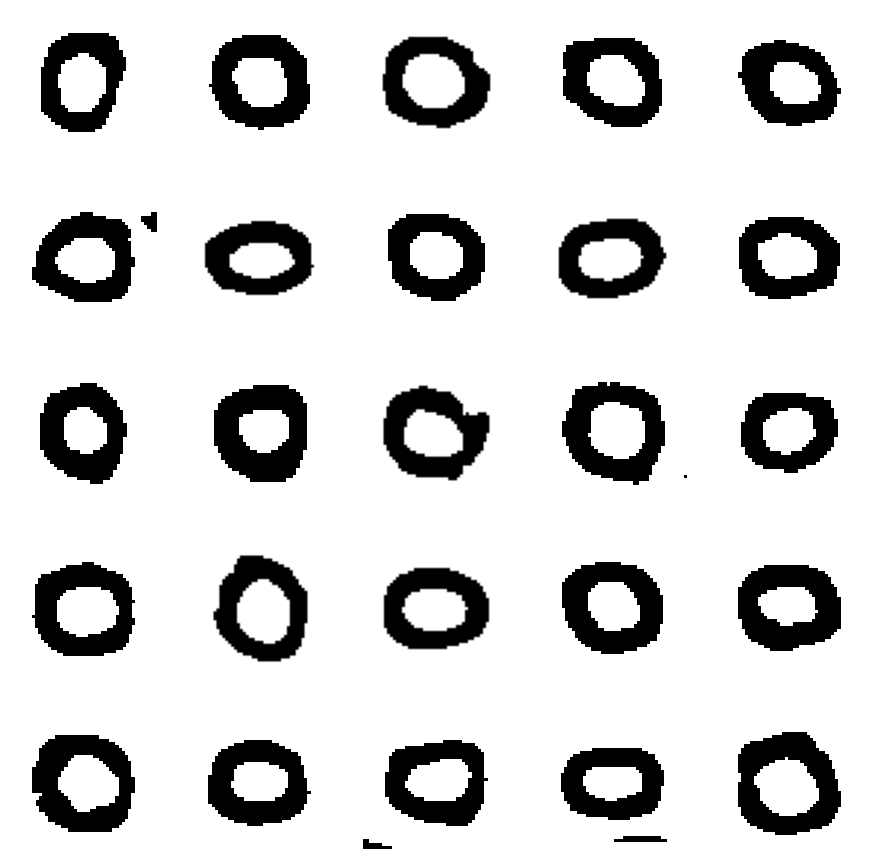


Cluster 221 : 71 images. Showing up to 25 samples:


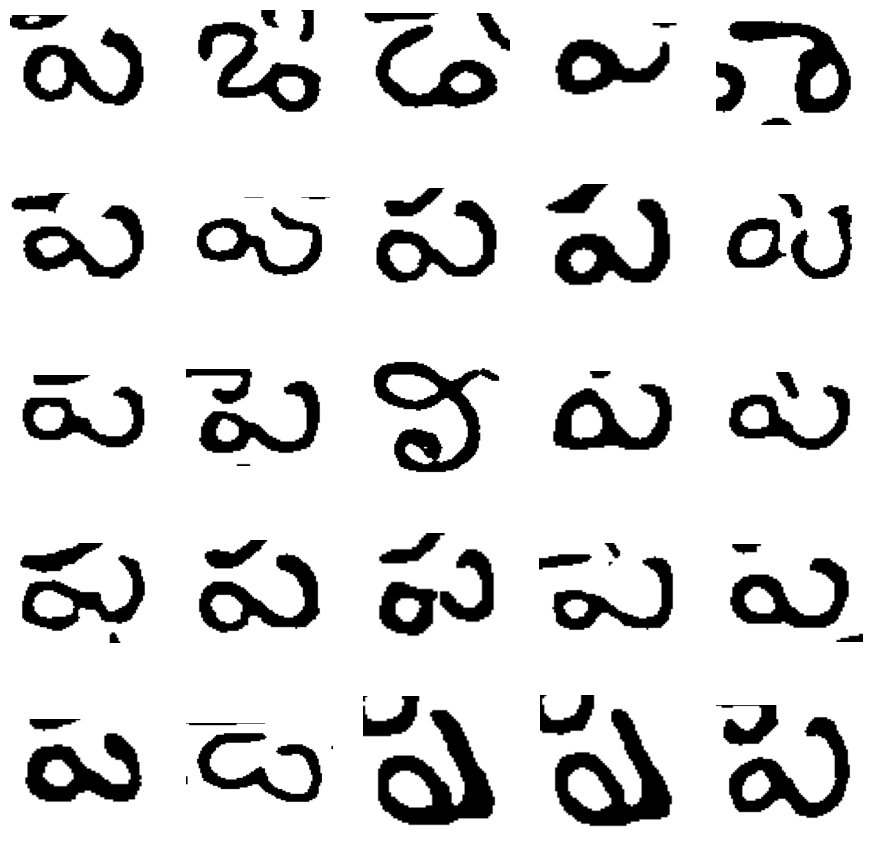


Cluster 247 : 71 images. Showing up to 25 samples:


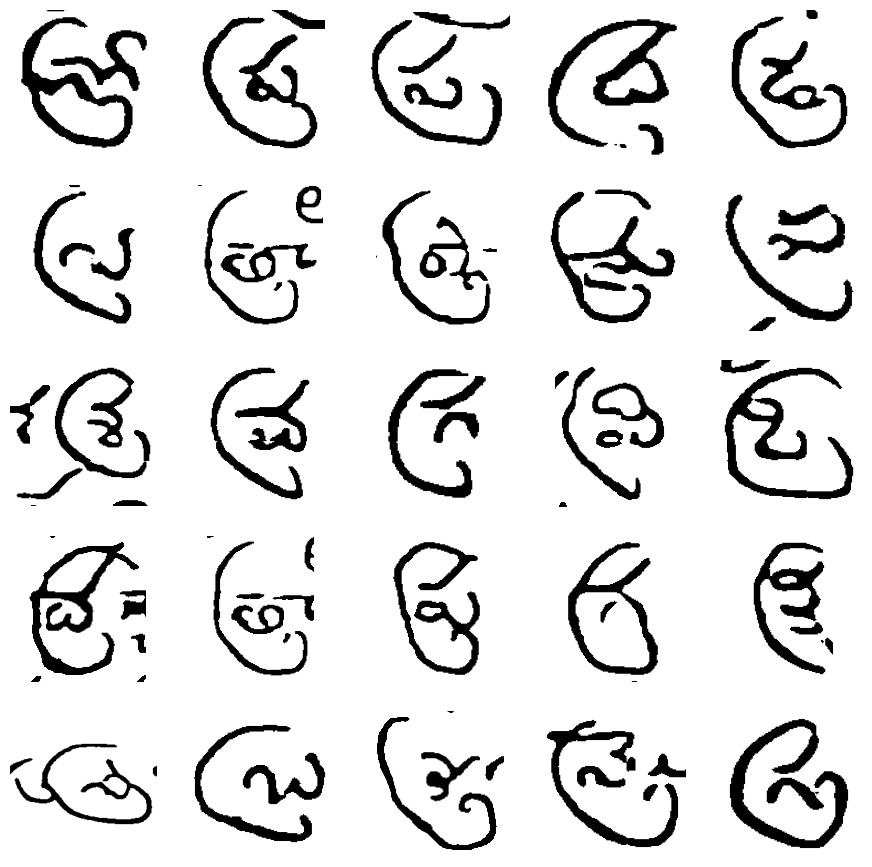


Cluster 757 : 70 images. Showing up to 25 samples:


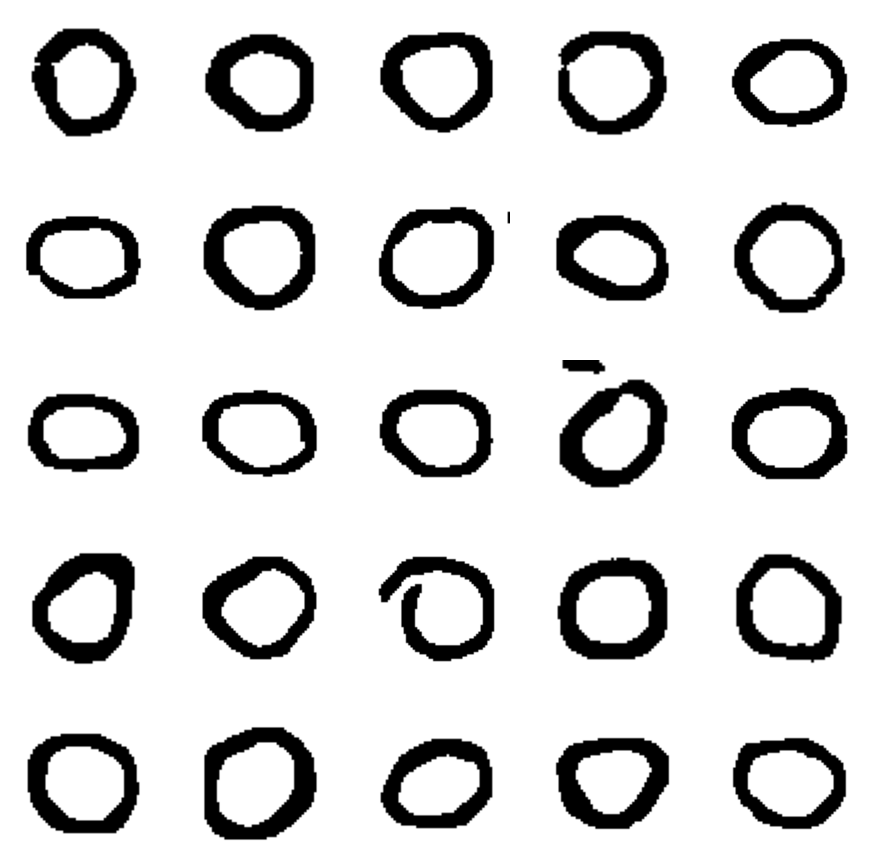

In [ ]:
clusters_to_inspect = [9,221,247,757] # Replace the cluster id's with them of which we are trying to inspect
# Visual inspection - shows sample images for given clusters (Jupyter)
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random, shutil
out_dir = Path(r"C:\Users\ASUS\Documents\Major\step_features_kmeans")
assign_csv = out_dir / "image_assignments_refined.csv"   # path -> ref_cluster
df_assign = pd.read_csv(assign_csv)

# Replace these cluster IDs with ones from the previous cell
# clusters_to_inspect = [156, 548, 914, 155, 293]  

for cid in clusters_to_inspect:
    rows = df_assign[df_assign['ref_cluster']==int(cid)]
    n = len(rows)
    print(f"\nCluster {cid} : {n} images. Showing up to 25 samples:")
    samples = rows['path'].sample(min(25,n)).tolist() if n>0 else []
    cols = 5
    rowsn = (len(samples)+cols-1)//cols
    fig, axs = plt.subplots(rowsn, cols, figsize=(cols*2.2, rowsn*2.2))
    axs = axs.flatten()
    for ax in axs:
        ax.axis('off')
    for ax, p in zip(axs, samples):
        try:
            img = Image.open(p).convert('RGB')
            ax.imshow(img)
        except Exception as e:
            ax.text(0.1,0.5,"ERR",fontsize=12)
    plt.show()


In [20]:
import torch, numpy as np, pandas as pd
from pathlib import Path

# Your working folder
out_dir = Path(r"C:\Users\ASUS\Documents\Major\step_features_kmeans")

# Load pseudo-labels created by EM refinement
labels = np.load(out_dir/"assignments_refined.npy")

# Load image paths
image_paths = pd.read_csv(out_dir/"image_paths.csv")["path"].tolist()

print("Total samples:", len(image_paths))
print("Total clusters:", labels.max() + 1)


Total samples: 28707
Total clusters: 976


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class PCLDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
            transforms.RandomRotation(8),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = Image.open(p).convert("L")       # grayscale
        img = img.resize((128, 128))
        img = self.transform(img)
        return img, self.labels[idx]


In [22]:
import torch.nn as nn
import torchvision.models as models

class EncoderWithHead(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()  # remove FC
        self.encoder = resnet

        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, proj_dim)
        )

    def forward(self, x):
        feat = self.encoder(x)
        z = self.projection(feat)
        return nn.functional.normalize(feat, dim=1), nn.functional.normalize(z, dim=1)


In [23]:
@torch.no_grad()
def momentum_update(model_q, model_k, m=0.999):
    for p_q, p_k in zip(model_q.parameters(), model_k.parameters()):
        p_k.data = p_k.data * m + p_q.data * (1. - m)

class MemoryQueue:
    def __init__(self, dim=128, size=16000):
        self.size = size
        self.ptr = 0
        self.queue = nn.functional.normalize(
            torch.randn(size, dim), dim=1
        ).cuda()

    @torch.no_grad()
    def update(self, keys):
        b = keys.shape[0]
        replace = min(b, self.size)
        self.queue[self.ptr:self.ptr+replace] = keys[:replace]
        self.ptr = (self.ptr + replace) % self.size

    def get(self):
        return self.queue


In [24]:
def pcl_loss(q, k, prototypes, labels, queue, temperature=0.2):
    # InfoNCE (instance contrast)
    pos = torch.sum(q * k, dim=1, keepdim=True) / temperature
    neg = torch.mm(q, queue.T) / temperature
    logits_infonce = torch.cat([pos, neg], dim=1)
    loss_infonce = -torch.log(
        torch.exp(pos) / torch.exp(logits_infonce).sum(dim=1, keepdim=True)
    ).mean()

    # ProtoNCE (cluster-level)
    proto_pos = torch.sum(q * prototypes[labels], dim=1, keepdim=True) / temperature
    proto_neg = torch.mm(q, prototypes.T) / temperature
    logits_proto = torch.cat([proto_pos, proto_neg], dim=1)
    loss_proto = -torch.log(
        torch.exp(proto_pos) / torch.exp(logits_proto).sum(dim=1, keepdim=True)
    ).mean()

    return loss_infonce + loss_proto


In [27]:
class PCLDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
            transforms.RandomRotation(8),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = Image.open(p).convert("RGB")   # IMPORTANT FIX: NOW 3 CHANNELS
        img = img.resize((128, 128))
        img = self.transform(img)
        return img, self.labels[idx]


In [28]:
import torch.nn as nn
import torchvision.models as models

class EncoderWithHead(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()  # remove FC
        self.encoder = resnet

        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, proj_dim)
        )

    def forward(self, x):
        feat = self.encoder(x)
        z = self.projection(feat)
        return nn.functional.normalize(feat, dim=1), nn.functional.normalize(z, dim=1)


In [29]:
@torch.no_grad()
def momentum_update(model_q, model_k, m=0.999):
    for p_q, p_k in zip(model_q.parameters(), model_k.parameters()):
        p_k.data = p_k.data * m + p_q.data * (1. - m)

class MemoryQueue:
    def __init__(self, dim=128, size=16000):
        self.size = size
        self.ptr = 0
        self.queue = nn.functional.normalize(
            torch.randn(size, dim), dim=1
        ).cuda()

    @torch.no_grad()
    def update(self, keys):
        b = keys.shape[0]
        replace = min(b, self.size)
        self.queue[self.ptr:self.ptr+replace] = keys[:replace]
        self.ptr = (self.ptr + replace) % self.size

    def get(self):
        return self.queue


In [30]:
def pcl_loss(q, k, prototypes, labels, queue, temperature=0.2):
    # InfoNCE (instance contrast)
    pos = torch.sum(q * k, dim=1, keepdim=True) / temperature
    neg = torch.mm(q, queue.T) / temperature
    logits_infonce = torch.cat([pos, neg], dim=1)
    loss_infonce = -torch.log(
        torch.exp(pos) / torch.exp(logits_infonce).sum(dim=1, keepdim=True)
    ).mean()

    # ProtoNCE (cluster-level)
    proto_pos = torch.sum(q * prototypes[labels], dim=1, keepdim=True) / temperature
    proto_neg = torch.mm(q, prototypes.T) / temperature
    logits_proto = torch.cat([proto_pos, proto_neg], dim=1)
    loss_proto = -torch.log(
        torch.exp(proto_pos) / torch.exp(logits_proto).sum(dim=1, keepdim=True)
    ).mean()

    return loss_infonce + loss_proto


In [ ]:

#       PCL TRAINING LOOP 


epochs = 5     # start with 5, increase to 20 later
temperature = 0.2

optimizer = torch.optim.Adam(model_q.parameters(), lr=1e-4)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    for imgs, lbl in loader:
        # move data to CPU device
        imgs = imgs.to(device)
        lbl = lbl.to(device)


        # Forward pass (query encoder)

        feat_q, z_q = model_q(imgs)


        # Momentum encoder forward

        with torch.no_grad():
            momentum_update(model_q, model_k, m=0.999)
            _, z_k = model_k(imgs)


        # Compute PCL loss

        loss = pcl_loss(
            z_q, z_k,
            prototypes,         # cluster prototypes
            lbl,                # pseudo labels
            queue.get(),        # memory queue
            temperature=temperature
        )


        # Backprop

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        queue.update(z_k.detach())

    print("Loss:", float(loss))

# Save encoder after training
torch.save(model_q.state_dict(), out_dir/"pcl_encoder_cpu.pth")
print("\nSaved encoder → pcl_encoder_cpu.pth")


Epoch 1/5
